# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Pitcher Overview](#Pitcher-Overview)
    - [General Pitch Data](#General-Pitch-Data)
    - [Pitch Usage](#Pitch-Usage)
    - [Pitch Usage by Batter Handedness](#Pitch-Usage-by-Batter-Handedness)
    - [Velocity by Pitch Type](#Velocity-by-Pitch-Type)
    - [Pitch Velocity by Pitch Number](#Pitch-Velocity-by-Pitch-Number)
- [Pitcher Stuff](#Pitcher-Stuff)
    - [Spin Rate by Pitch Type](#Spin-Rate-by-Pitch-Type)
    - [Velocity & Spin Rate](#Velocity-&-Spin-Rate)
    - [Spin Axis](#Spin-Axis)
    - [Spin Efficiency](#Spin-Efficiency)
    - [HB & VB Axis](#Horizontal-&-Vertical-Break-Axis)
    - [HB & HB Due to Magnus Force](#Horizontal-&-Vertical-Break-Due-to-Magnus-Force-Axis)
    - [Release Position](#Release-Postion)
    - [Release Extension](#Release-Extension-(Side))
    - [Avg. Bauer Units by Pitch Type](#Bauer-Units)
- [Count Breakdown](#Count-Breakdown)
    - [Pitch Usage by Count](#Pitch-Usage-by-Count)
- [Heatmaps](#Heatmaps)
    - [Pitch Location by Pitch Type](#Pitch-Location-by-Pitch-Type)
    - [Qaulity Contact Heatmap - All Pitches](#Launch-Speed-Angle)
    - [Slider Heatmaps](#Slider-Heatmaps)
    - [4-Seam Heatmaps](#4-Seam-Heatmaps)
    - [Curveball Heatmaps](#Curveball-Heatmaps)
    - [Changeup Heatmaps](#Changeup-Heatmaps)


# Imports

In [1]:
import math
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.ticker import PercentFormatter

import warnings
warnings.filterwarnings('ignore')

# Data 

In [2]:
doolittle = pd.read_csv('../data/sean-doolittle.csv')
doolittle.drop(columns = ['Unnamed: 0'], inplace = True)
doolittle.dropna(subset = ['pitch_type'], inplace = True)

# Font Dictionary
font_title = {
    'size': 14,
    'weight': 'bold',
    'verticalalignment': 'center_baseline',
    'horizontalalignment': 'center'
}

pd.set_option('max_columns', None)
print(doolittle.shape)
doolittle.head(2)

(866, 84)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,post_away_score,post_home_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,Mx,Mz,phi,theta,is_strike,pitch_count,plate_-x,pfx_-x,M-x,spin_eff,spin_eff%,true_spin,bauer_units,swing_miss
0,FF,2021-07-27,94.7,2.07,5.79,"Doolittle, Sean",519203,448281,out,hit_into_play,14,Anthony Rizzo flies out to center fielder Shog...,L,L,CHC,CIN,X,8.0,fly_ball,0,0,2021,0.59,19.32,0.00,1.33,664023.0,621550.0,592178.0,2,7,Bot,98.6,72.18,663886,-6.740616,-137.582658,-9.559681,8.982808,29.831752,-9.763219,3.49,1.60,321.0,89.1,34.0,94.9,2330.0,6.4,633160,54.07,0.037,0.054,0.0,1.0,0.0,0.0,3.0,60,1,4-Seam Fastball,2,5,5,2,Infield shift,Standard,151,-0.095,-0.806,NaN,NaN,NaN,NaN,1,0-0,-0.00,-7.08,NaN,NaN,NaN,NaN,24.604013,0
1,FF,2021-07-27,95.3,2.09,5.83,"Doolittle, Sean",592178,448281,walk,ball,12,Kris Bryant walks. Ian Happ to 3rd. Patri...,R,L,CHC,CIN,B,NaN,NaN,3,2,2021,0.49,19.92,1.33,4.11,NaN,664023.0,621550.0,2,7,Bot,NaN,NaN,663886,-3.101205,-138.766057,-2.626793,7.036064,31.895328,-10.316987,3.37,1.69,NaN,NaN,NaN,95.2,2359.0,6.2,633160,54.26,NaN,NaN,0.7,1.0,0.0,0.0,NaN,59,7,4-Seam Fastball,2,5,5,2,Standard,Standard,158,0.045,0.307,NaN,NaN,NaN,NaN,0,3-2,-1.33,-5.88,NaN,NaN,NaN,NaN,24.753410,0


In [3]:
gen_data = doolittle[['pitch_type', 'release_speed', 'release_spin_rate',
                      'true_spin', 'spin_eff', 'phi', 'pfx_z', 'pfx_-x',
                      'is_strike', 'release_pos_x', 'release_pos_z', 'bauer_units']]
col_dict = {
    'release_speed': 'velo', 'release_spin_rate': 'spin', 'phi': 'spin_axis', 'pfx_z': 'hb', 'pfx_-x': 'vb',
    'is_strike': 'strike', 'release_pos_z': 'r_height', 'release_pos_x': 'r_side'
}
gen_data.rename(columns = col_dict, inplace = True)

In [4]:
#doolittle.pitch_type.value_counts(normalize=True)
r_doolittle = doolittle.loc[(doolittle['player_name'] == 'Doolittle, Sean') & (doolittle['stand'] == 'R')].copy()
l_doolittle = doolittle.loc[(doolittle['player_name'] == 'Doolittle, Sean') & (doolittle['stand'] == 'L')].copy()
# all hitters
ff = doolittle.loc[doolittle['pitch_type'] == 'FF']
cu = doolittle.loc[doolittle['pitch_type'] == 'CU']
sl = doolittle.loc[doolittle['pitch_type'] == 'SL']
fs = doolittle.loc[doolittle['pitch_type'] == 'FS']
# RHH
r_ff = r_doolittle.loc[r_doolittle['pitch_type'] == 'FF']
r_cu = r_doolittle.loc[r_doolittle['pitch_type'] == 'CU']
r_sl = r_doolittle.loc[r_doolittle['pitch_type'] == 'SL']
r_fs = r_doolittle.loc[r_doolittle['pitch_type'] == 'FS']
# LHH
l_ff = l_doolittle.loc[l_doolittle['pitch_type'] == 'FF']
l_cu = l_doolittle.loc[l_doolittle['pitch_type'] == 'CU']
l_sl = l_doolittle.loc[l_doolittle['pitch_type'] == 'SL']
l_fs = l_doolittle.loc[l_doolittle['pitch_type'] == 'FS']
order = ['FF', 'CU', 'SL', 'FS']

# Pitcher Overview

### General Pitch Data

In [5]:
gen_data.groupby(['pitch_type'], sort = False).mean()

,velo,spin,true_spin,spin_eff,spin_axis,hb,vb,strike,r_side,r_height,bauer_units
pitch_type,,,,,,,,,,,
FF,93.082454,2260.757489,1836.341299,0.810455,165.846154,20.023248,-3.623077,0.703704,1.757863,6.082806,24.287463
SL,84.180851,2260.042553,319.597273,0.143030,218.484848,5.956596,2.872340,0.574468,2.021915,6.078085,26.863046
CU,79.728205,2405.307692,356.355789,0.149474,257.315789,0.967692,7.756923,0.551282,2.093462,5.903590,30.198055
FS,80.420513,982.230769,669.579310,0.702414,149.968750,9.603077,-6.750769,0.461538,1.972821,5.942821,12.197656


### Pitch Usage

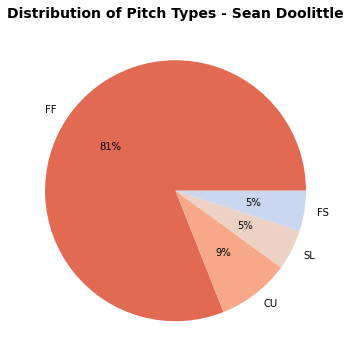

In [6]:
plt.figure(figsize = (8, 6))

dist = round(doolittle.pitch_type.value_counts(normalize = True), 2)
#labels
color = sns.color_palette('coolwarm_r')

plt.pie(dist, labels = order, colors = color, autopct = '%.0f%%')
plt.title('Distribution of Pitch Types - Sean Doolittle', fontdict = font_title, pad = 15);

### Pitch Usage by Batter Handedness

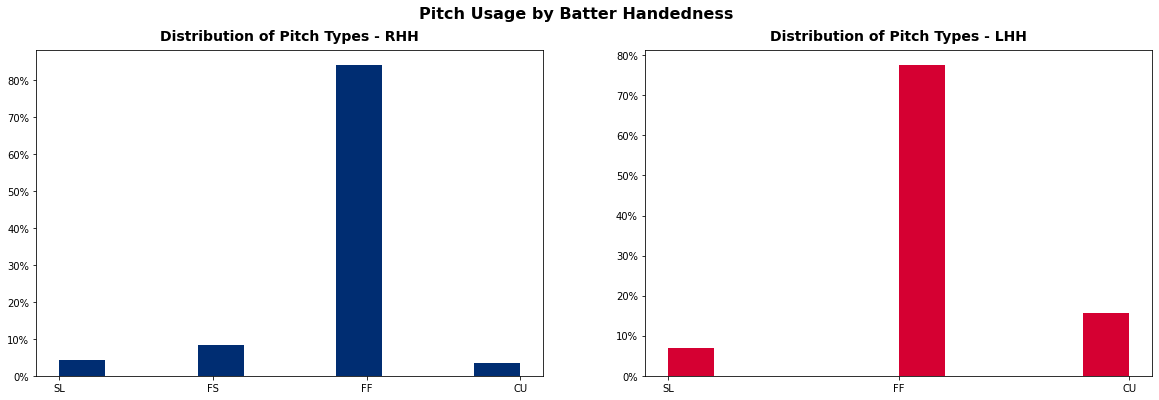

In [7]:
blue = '#002D72'
red = '#D50032'
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
fig.suptitle('Pitch Usage by Batter Handedness', fontsize = 16, fontweight = 'bold')

dist_r = r_doolittle.pitch_type.sort_values(ascending = False)
axs[0].hist(dist_r, weights = np.ones(len(dist_r)) / len(dist_r), color = blue)
axs[0].yaxis.set_major_formatter(PercentFormatter(1))
axs[0].set_title('Distribution of Pitch Types - RHH', fontdict = font_title, pad = 15)

dist_l = l_doolittle.pitch_type.sort_values(ascending = False)
axs[1].hist(dist_l, weights = np.ones(len(dist_l)) / len(dist_l), color = red)
axs[1].yaxis.set_major_formatter(PercentFormatter(1))
axs[1].set_title('Distribution of Pitch Types - LHH', fontdict = font_title, pad = 15);

### Velocity by Pitch Type

4-Seam velo sits: 92 - 94 mph,  max: 97.8 mph
Curve velo sits: 79 - 81 mph,  max: 83.6 mph
Slider velo sits: 83 - 85 mph,  max: 88.8 mph
Split-Finger velo sits: 80 - 81 mph,  max: 82.5 mph


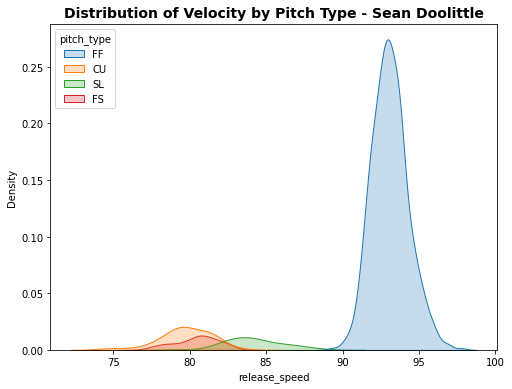

In [8]:
plt.figure(figsize = (8, 6))

ax = sns.kdeplot(data = doolittle, x = 'release_speed', shade = 'fill', hue = 'pitch_type',
            hue_order = order, palette = 'tab10')
sns.move_legend(ax, 'upper left')
plt.title('Distribution of Velocity by Pitch Type - Sean Doolittle', fontdict = font_title, pad = 12)
print('4-Seam velo sits:',round(ff['release_speed'].quantile(.25)),'-',round(ff['release_speed'].quantile(.75)), 
      'mph, ', 'max:', round(ff['release_speed'].max(), 2), 'mph')
print('Curve velo sits:',round(cu['release_speed'].quantile(.25)),'-',round(cu['release_speed'].quantile(.75)), 
      'mph, ','max:',round(cu['release_speed'].max(), 2),'mph')
print('Slider velo sits:',round(sl['release_speed'].quantile(.25)),'-',round(sl['release_speed'].quantile(.75)), 
      'mph, ','max:',round(sl['release_speed'].max(),2),'mph')
print('Split-Finger velo sits:',round(fs['release_speed'].quantile(.25)),'-',
      round(fs['release_speed'].quantile(.75)),'mph, ','max:',round(fs['release_speed'].max(), 2),'mph');

### Pitch Velocity by Pitch Number

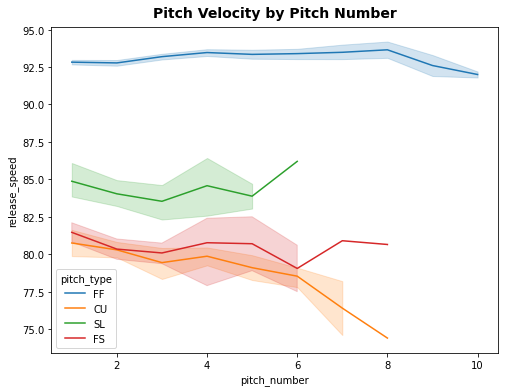

In [9]:
plt.figure(figsize = (8, 6))

sns.lineplot(data = doolittle, x = 'pitch_number', y = 'release_speed', hue = 'pitch_type',
             hue_order = order, palette = 'tab10')
plt.title('Pitch Velocity by Pitch Number', fontdict = font_title, pad = 15);

# Pitcher Stuff

### Spin Rate by Pitch Type

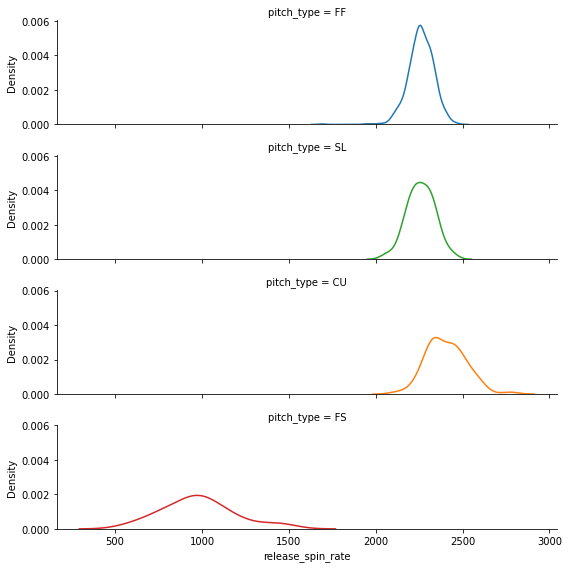

In [10]:
g = sns.FacetGrid(doolittle, row = 'pitch_type', hue = 'pitch_type', height = 2, aspect = 4, hue_order = order);
g.map(sns.kdeplot, 'release_spin_rate', palette = 'tab10');

### Velocity & Spin Rate

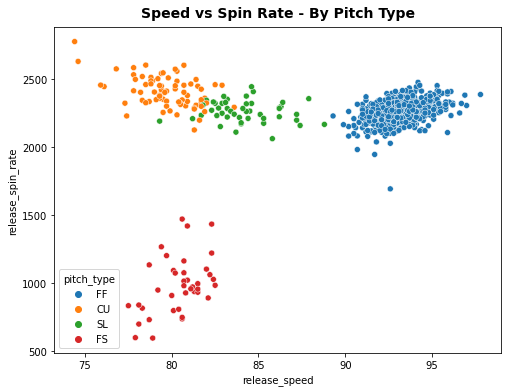

In [11]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = doolittle, x = 'release_speed', y = 'release_spin_rate', hue = 'pitch_type', 
                hue_order = order, palette = 'tab10')
plt.title('Speed vs Spin Rate - By Pitch Type', fontdict = font_title, pad = 15);

### Spin Axis

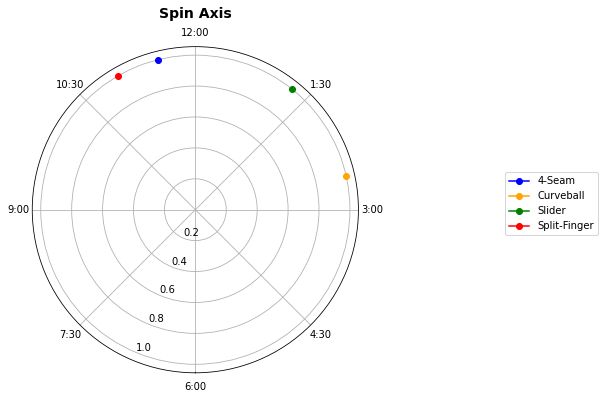

In [12]:
ff_tilt = ff['phi'].mean()
cu_tilt = cu['phi'].mean()
sl_tilt = sl['phi'].mean()
fs_tilt = fs['phi'].mean()
ax = plt.figure(figsize = (8, 6))
ax = plt.subplot(polar = True, theta_direction = -1)
ax.plot(math.radians(ff_tilt), 1, color = 'blue', marker = 'o', label = '4-Seam')
ax.plot(math.radians(cu_tilt), 1, color = 'orange', marker = 'o', label = 'Curveball')
ax.plot(math.radians(sl_tilt), 1, color = 'green', marker = 'o', label = 'Slider')
ax.plot(math.radians(fs_tilt), 1, color = 'red', marker = 'o', label = 'Split-Finger')
ticks = ['6:00', '7:30', '9:00', '10:30', '12:00', '1:30', '3:00', '4:30']
ax.set_xticklabels(ticks)        
ax.legend(bbox_to_anchor=(1.75, .63))
ax.set_theta_zero_location("S")
ax.set_title('Spin Axis', fontdict = font_title, pad = 15);

### Spin Efficiency

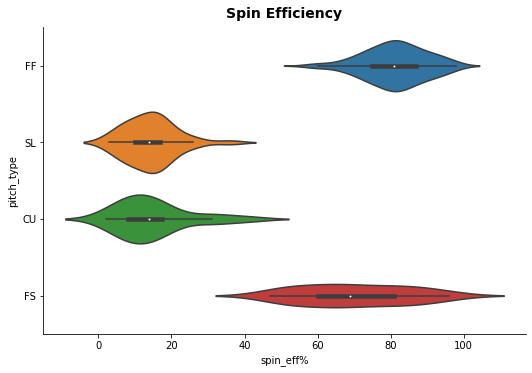

In [13]:
sns.catplot(data = doolittle, x = 'spin_eff%', y = 'pitch_type', kind = 'violin', aspect= 1.5, palette = 'tab10')
plt.title('Spin Efficiency', fontdict = font_title, pad = 15);

### Horizontal & Vertical Break Axis

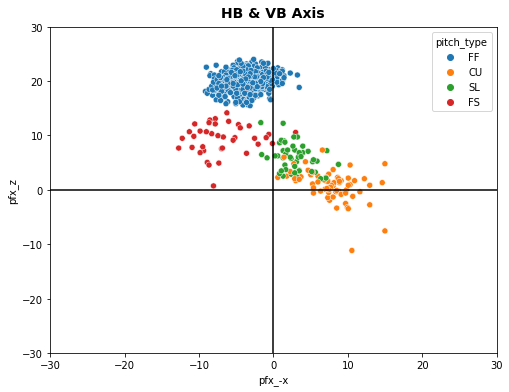

In [14]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = doolittle, x = 'pfx_-x', y = 'pfx_z', hue = 'pitch_type', 
                hue_order = order, palette = 'tab10')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('HB & VB Axis', fontdict = font_title, pad = 15);

### Horizontal & Vertical Break Due to Magnus Force Axis

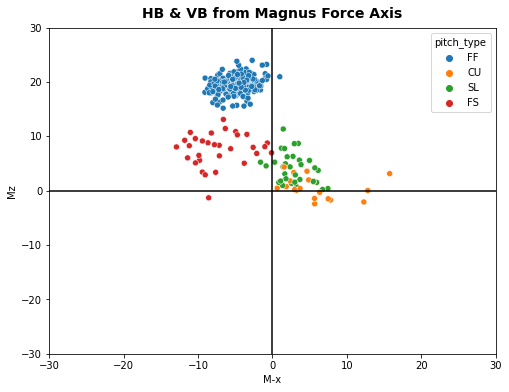

In [15]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = doolittle, x = 'M-x', y = 'Mz', hue = 'pitch_type', 
                hue_order = order, palette = 'tab10')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('HB & VB from Magnus Force Axis', fontdict = font_title, pad = 15);

### Release Postion

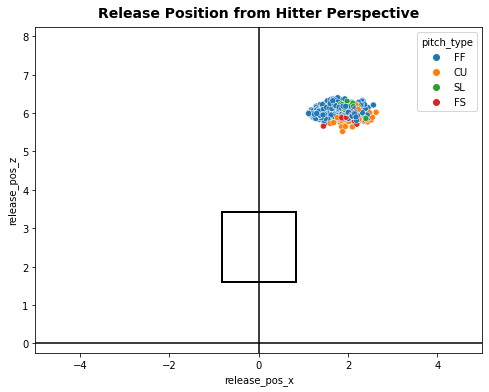

In [16]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = doolittle, x = 'release_pos_x', y = 'release_pos_z', hue = 'pitch_type', 
                 hue_order = order, palette = 'tab10')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
rect = mpatches.Rectangle((left, bottom), width, height,
                          fill = False, color = 'black', linewidth = 2)
plt.gca().add_patch(rect)
plt.title('Release Position from Hitter Perspective', fontdict = font_title, pad = 15);

### Release Extension (Side)

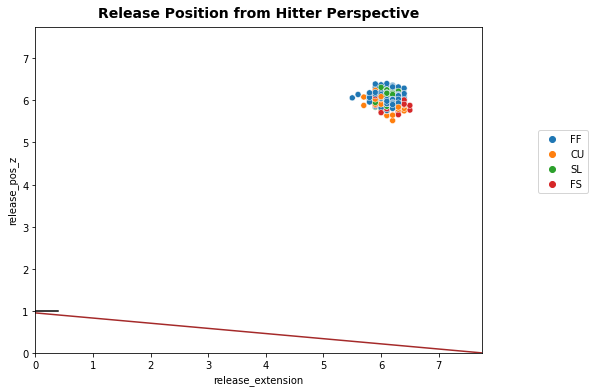

In [17]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = doolittle, x = 'release_extension', y = 'release_pos_z', hue = 'pitch_type', 
                hue_order = order, palette = 'tab10')
plt.xlim(0, 7.75), plt.ylim(0, 7.75)
plt.axline((0, .95), (7.75,0), color = 'brown'), plt.axhline(1, 0, .05, color = 'black')
plt.legend(bbox_to_anchor=(1.25, .7))
plt.title('Release Position from Hitter Perspective', fontdict = font_title, pad = 15);

### Bauer Units

4-Seam Avg Bauer Units: 24.29
Curveball Avg Bauer Units: 30.2
Slider Avg Bauer Units: 26.86
Split-Finger Avg Bauer Units: 12.2


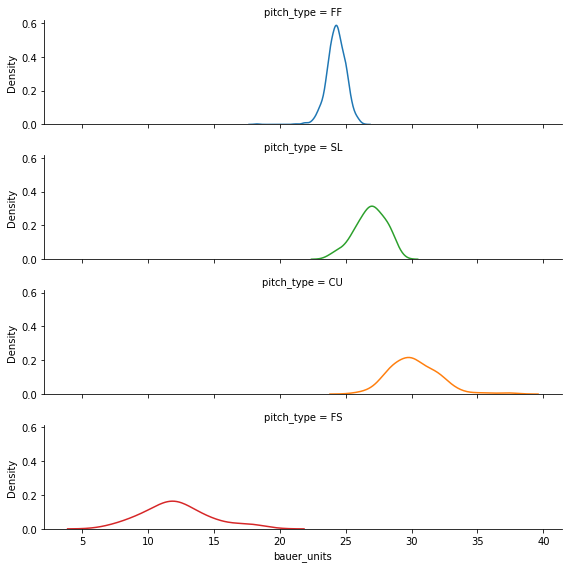

In [18]:
g = sns.FacetGrid(doolittle, row = 'pitch_type', hue = 'pitch_type', height = 2, aspect = 4, hue_order = order)
g.map(sns.kdeplot, 'bauer_units', palette = 'tab10')
print('4-Seam Avg Bauer Units:', round(ff['bauer_units'].mean(), 2))
print('Curveball Avg Bauer Units:', round(cu['bauer_units'].mean(), 2))
print('Slider Avg Bauer Units:', round(sl['bauer_units'].mean(), 2))
print('Split-Finger Avg Bauer Units:', round(fs['bauer_units'].mean(), 2))

# Count Breakdown

### Pitch Usage by Count

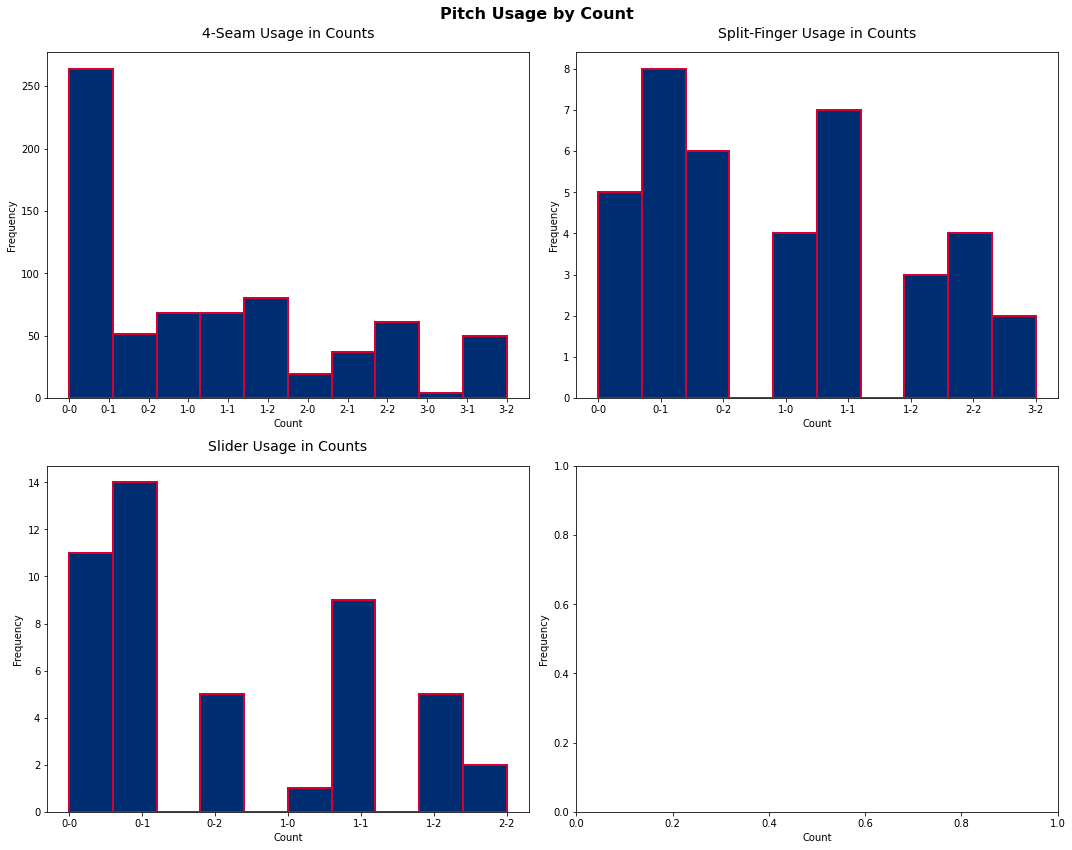

In [19]:
fig, axs = plt.subplots(2, 2, figsize = (15, 12))
fig.suptitle('Pitch Usage by Count', fontsize = 16, fontweight = 'bold')
plt.setp(axs[0:, :], xlabel = 'Count')
plt.setp(axs[:, 0:], ylabel = 'Frequency')
axs[0][0].hist(ff['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[0][0].set_title('4-Seam Usage in Counts', fontsize = 14, pad = 15)

axs[0][1].hist(fs['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[0][1].set_title('Split-Finger Usage in Counts', fontsize = 14, pad = 15)

axs[1][0].hist(sl['pitch_count'].sort_values(ascending = True), color = blue, edgecolor = red, linewidth = 2)
axs[1][0].set_title('Slider Usage in Counts', fontsize = 14, pad = 15)
plt.tight_layout();

# Heatmaps
*All From Hitters' Perspective

### Pitch Location by Pitch Type

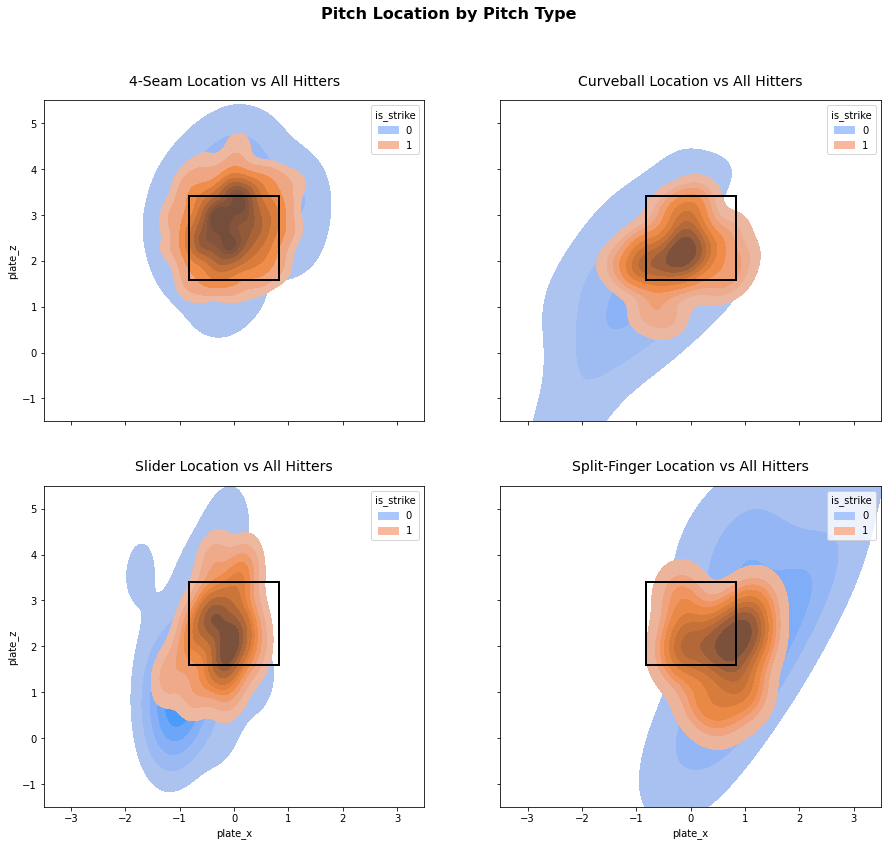

In [20]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('Pitch Location by Pitch Type', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5), plt.axis(ymin = -1.5, ymax = 5.5)
sns.kdeplot(ax = axs[0][0],data=ff,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('4-Seam Location vs All Hitters', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[0][1],data=cu,x='plate_x',y='plate_z',fill = True,hue='is_strike',palette='coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Curveball Location vs All Hitters', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][0],data=sl,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Slider Location vs All Hitters', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][1],data=fs,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Split-Finger Location vs All Hitters', fontsize = 14, pad = 15);

### Launch Speed Angle
1: weak 2: topped 3: under 4: flare/burner 5: solid contact 6: barrel

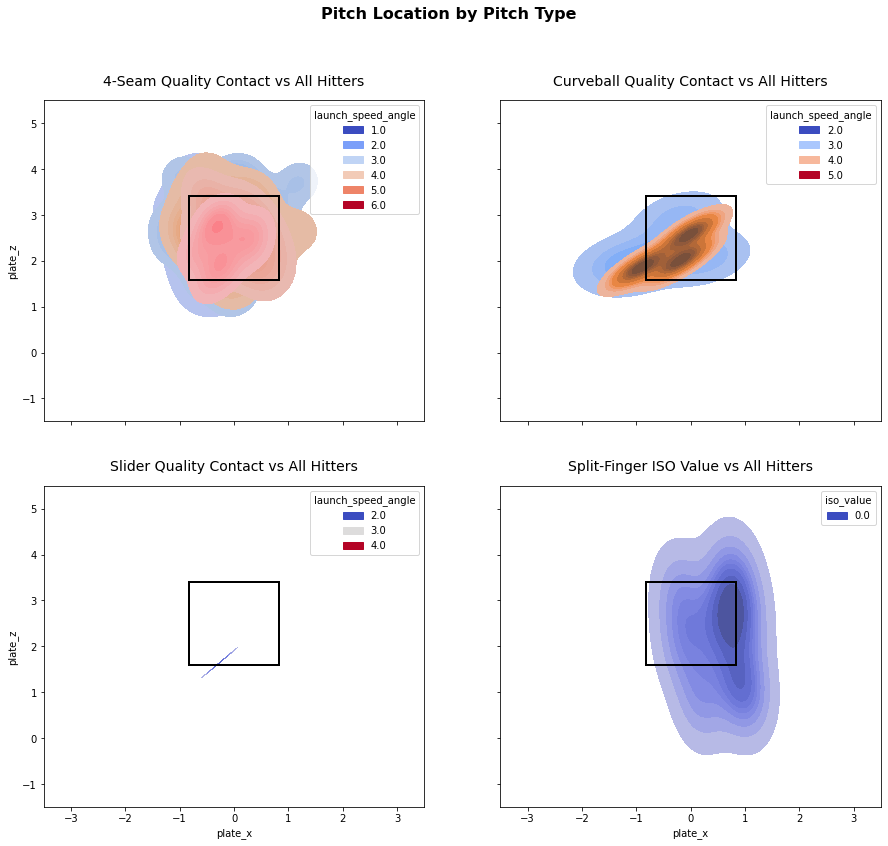

In [21]:
fig, axs = plt.subplots(2, 2, figsize = (15, 13), sharex = True, sharey = True)
fig.suptitle('Pitch Location by Pitch Type', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5), plt.axis(ymin = -1.5, ymax = 5.5)
sns.kdeplot(ax=axs[0][0],data=ff,x='plate_x',y='plate_z',fill=True,hue='launch_speed_angle',palette='coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('4-Seam Quality Contact vs All Hitters', fontsize = 14, pad = 15)
sns.kdeplot(ax=axs[0][1],data=cu,x='plate_x',y='plate_z',fill = True,hue='launch_speed_angle',palette='coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Curveball Quality Contact vs All Hitters', fontsize = 14, pad = 15)
sns.kdeplot(ax=axs[1][0],data=sl,x='plate_x',y='plate_z',fill=True,hue='launch_speed_angle',palette='coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Slider Quality Contact vs All Hitters', fontsize = 14, pad = 15)
sns.kdeplot(ax=axs[1][1],data=fs,x='plate_x',y='plate_z',fill=True,hue='iso_value',palette='coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Split-Finger ISO Value vs All Hitters', fontsize = 14, pad = 15);

# Heatmaps

### 4-Seam Heatmaps

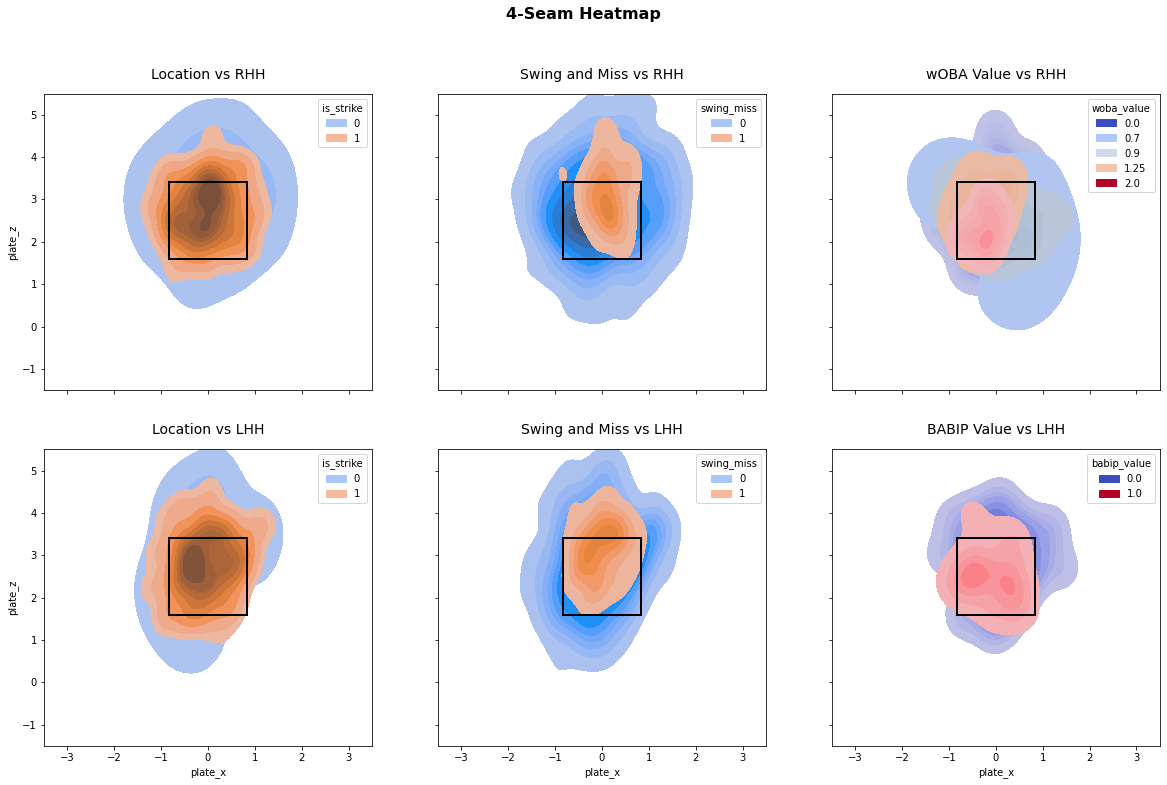

In [22]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('4-Seam Heatmap', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5), plt.axis(ymin = -1.5, ymax = 5.5)
sns.kdeplot(ax = axs[0][0],data=r_ff,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[0][1],data=r_ff,x='plate_x',y='plate_z',fill = True,hue='swing_miss',palette='coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[0][2],data=r_ff,x='plate_x',y='plate_z',fill=True,hue='woba_value',palette='coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('wOBA Value vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][0],data=l_ff,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][1],data=l_ff,x='plate_x',y ='plate_z',fill=True,hue='swing_miss',palette='coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][2],data=l_ff,x='plate_x',y='plate_z',fill=True,hue='babip_value',palette='coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('BABIP Value vs LHH', fontsize = 14, pad = 15);

### Curveball Heatmaps

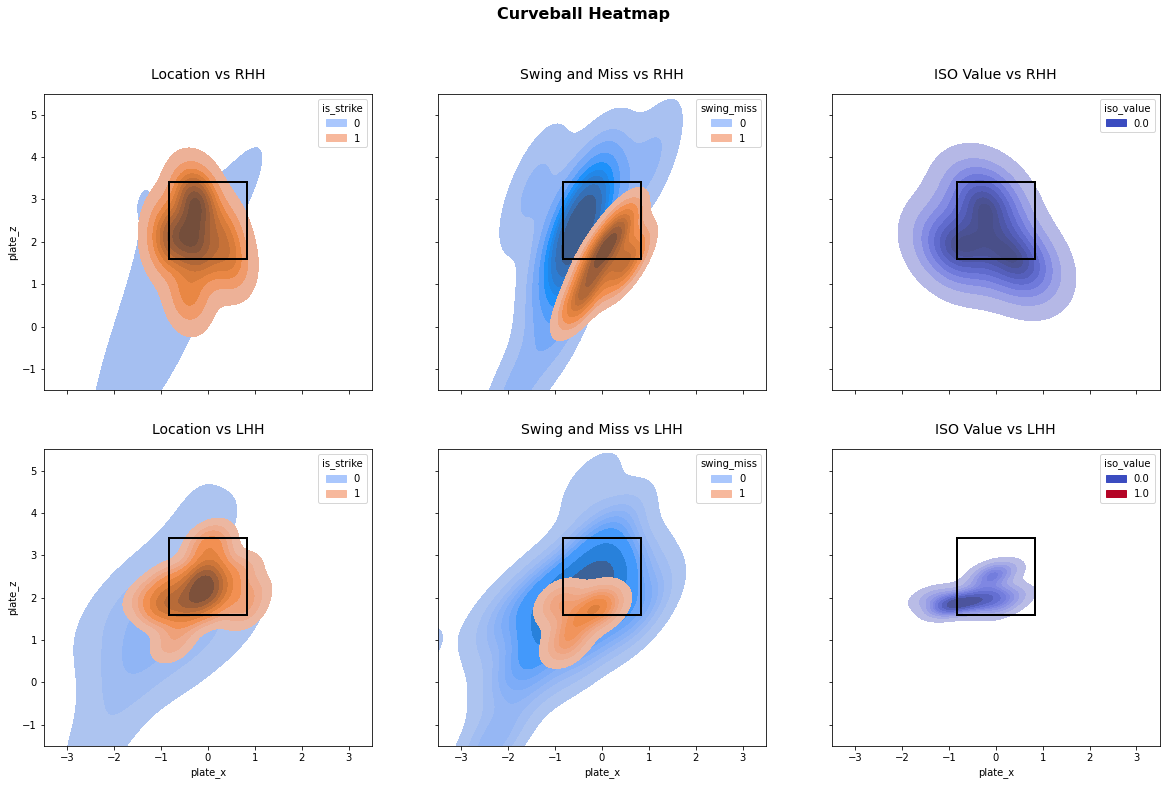

In [23]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Curveball Heatmap', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5), plt.axis(ymin = -1.5, ymax = 5.5)
sns.kdeplot(ax = axs[0][0],data=r_cu,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[0][1],data=r_cu,x='plate_x',y='plate_z',fill = True,hue='swing_miss',palette='coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[0][2],data=r_cu,x='plate_x',y='plate_z',fill=True,hue='iso_value',palette='coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('ISO Value vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][0],data=l_cu,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][1],data=l_cu,x='plate_x',y ='plate_z',fill=True,hue='swing_miss',palette='coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][2],data=l_cu,x='plate_x',y='plate_z',fill=True,hue='iso_value',palette='coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('ISO Value vs LHH', fontsize = 14, pad = 15);

### Slider Heatmaps

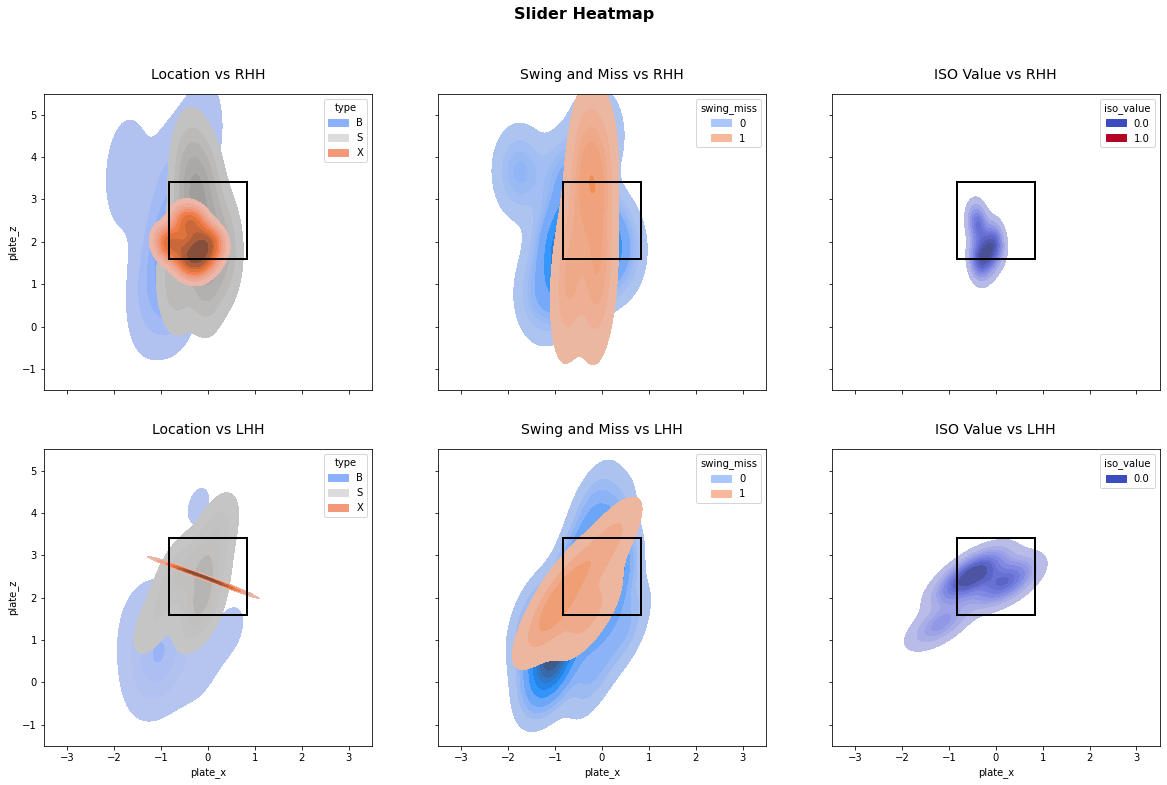

In [24]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Slider Heatmap', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5), plt.axis(ymin = -1.5, ymax = 5.5)
sns.kdeplot(ax = axs[0][0],data=r_sl,x='plate_x',y='plate_z',fill=True,hue='type',palette='coolwarm')
axs[0][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][0].set_title('Location vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[0][1],data=r_sl,x='plate_x',y='plate_z',fill = True,hue='swing_miss',palette='coolwarm')
axs[0][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][1].set_title('Swing and Miss vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[0][2],data=r_sl,x='plate_x',y='plate_z',fill=True,hue='iso_value',palette='coolwarm')
axs[0][2].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0][2].set_title('ISO Value vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][0],data=l_sl,x='plate_x',y='plate_z',fill=True,hue='type',palette='coolwarm')
axs[1][0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][0].set_title('Location vs LHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][1],data=l_sl,x='plate_x',y='plate_z',fill = True,hue='swing_miss',palette='coolwarm')
axs[1][1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][1].set_title('Swing and Miss vs LHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1][2],data=l_sl,x='plate_x',y='plate_z',fill=True,hue='iso_value',palette='coolwarm')
axs[1][2].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1][2].set_title('ISO Value vs LHH', fontsize = 14, pad = 15);

### Split-Finger Heatmaps

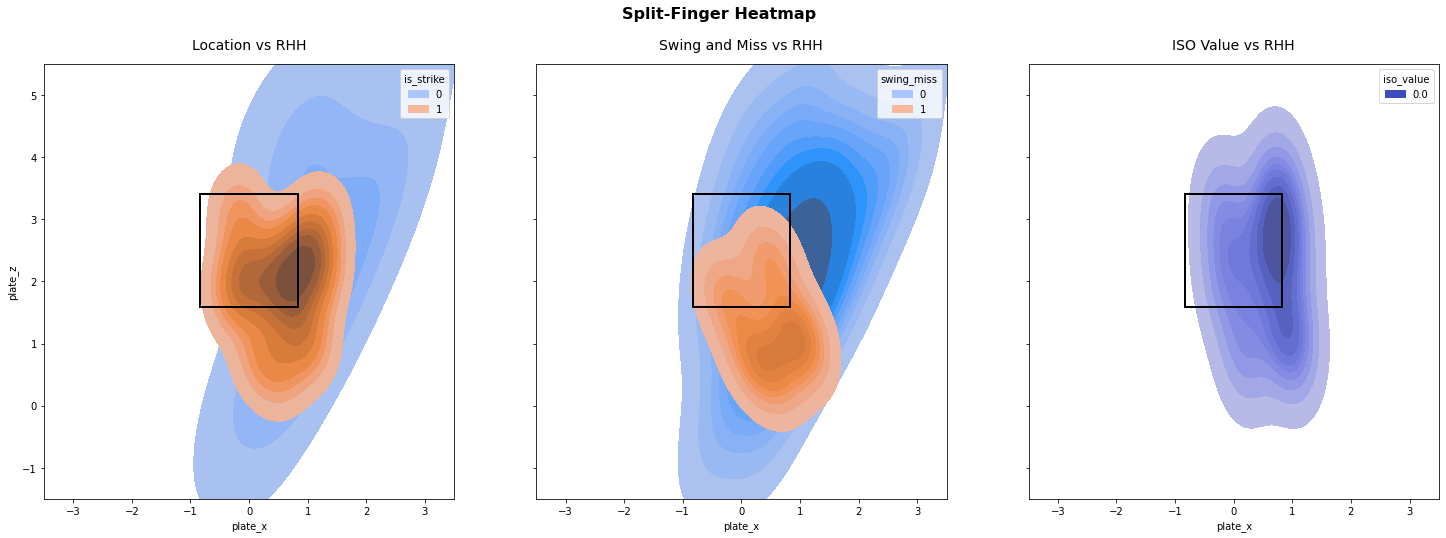

In [25]:
fig, axs = plt.subplots(1, 3, figsize = (25, 8), sharex = True, sharey = True)
fig.suptitle('Split-Finger Heatmap', fontsize = 16, fontweight = 'bold')
plt.axis(xmin = -3.5, xmax = 3.5), plt.axis(ymin = -1.5, ymax = 5.5)
sns.kdeplot(ax = axs[0],data=r_fs,x='plate_x',y='plate_z',fill=True,hue='is_strike',palette='coolwarm')
axs[0].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[0].set_title('Location vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[1],data=r_fs,x='plate_x',y='plate_z',fill = True,hue='swing_miss',palette='coolwarm')
axs[1].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[1].set_title('Swing and Miss vs RHH', fontsize = 14, pad = 15)
sns.kdeplot(ax = axs[2],data=r_fs,x='plate_x',y='plate_z',fill=True,hue='iso_value',palette='coolwarm')
axs[2].add_patch(Rectangle((-.83, 1.59), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
axs[2].set_title('ISO Value vs RHH', fontsize = 14, pad = 15);